# Coursework1: Convolutional Neural Networks 

## instructions

Please submit a version of this notebook containing your answers **together with your trained model** on CATe as CW2.zip. Write your answers in the cells below each question.

### Setting up working environment 

For this coursework you will need to train a large network, therefore we recommend you work with Google Colaboratory, which provides free GPU time. You will need a Google account to do so. 

Please log in to your account and go to the following page: https://colab.research.google.com. Then upload this notebook.

For GPU support, go to "Edit" -> "Notebook Settings", and select "Hardware accelerator" as "GPU".

You will need to install pytorch by running the following cell:

In [0]:
!pip install torch torchvision

## Introduction

For this coursework you will implement one of the most commonly used model for image recognition tasks, the Residual Network. The architecture is introduced in 2015 by Kaiming He, et al. in the paper ["Deep residual learning for image recognition"](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf). 
<br>

In a residual network, each block contains some convolutional layers, plus "skip" connections, which allow the activations to by pass a layer, and then be summed up with the activations of the skipped layer. The image below illustrates a building block in residual networks.

![resnet-block](utils/resnet-block.png)

Depending on the number of building blocks, resnets can have different architectures, for example ResNet-50, ResNet-101 and etc. Here you are required to build ResNet-18 to perform classification on the CIFAR-10 dataset, therefore your network will have the following architecture:

![resnet](utils/resnet.png)

## Part 1 (40 points)

In this part, you will use basic pytorch operations to define the 2D convolution, max pooling operation, linear layer as well as 2d batch normalization. 

### YOUR TASK

- implement the forward pass for Conv2D, MaxPool2D, Linear and BatchNorm2d
- You are **NOT** allowed to use the torch.nn modules

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class Conv2d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=0,
                 bias=True):

        super(Conv2d, self).__init__()
        """
        An implementation of a convolutional layer.

        The input consists of N data points, each with C channels, height H and
        width W. We convolve each input with F different filters, where each filter
        spans all C channels and has height HH and width WW.

        Parameters:
        - w: Filter weights of shape (F, C, HH, WW)
        - b: Biases, of shape (F,)
        - kernel_size: Size of the convolving kernel
        - stride: The number of pixels between adjacent receptive fields in the
            horizontal and vertical directions.
        - padding: The number of pixels that will be used to zero-pad the input.
        """

        ########################################################################
        # TODO: Define the parameters used in the forward pass                 #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        self.C = in_channels 
        self.F = out_channels 
        self.S = stride 
        self.P = padding
        self.bias = bias

        if isinstance(kernel_size, tuple): 
          self.HH = kernel_size[0] 
          self.WW = kernel_size[1] 
        else: 
          self.HH = kernel_size 
          self.WW = kernel_size

        self.W = torch.rand(self.C, self.F, self.HH, self.WW, requires_grad=True)
        if bias:
          self.b = torch.rand((self.F,), requires_grad=True)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data, of shape (N, F, H', W').
        """

        ########################################################################
        # TODO: Implement the forward pass                                     #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # calculate output height/width 
        N, C, H_prev, W_prev = x.shape
        assert self.C == C, "Error: Incorrect number of data channels"
        H_out = (H_prev-self.HH+2*self.P)//self.S + 1 # most general case with floor 
        W_out = (W_prev-self.WW+2*self.P)//self.S + 1 

        # unfold input and filter weight tensors + matrix multiply
        x_unfold = F.unfold(x, kernel_size=(self.HH, self.WW), padding=self.P, stride=self.S).transpose(1, 2)
        W_out_unfold = self.W.view(self.W.size(0), -1).t()
        out_unfold = (x_unfold @ W_out_unfold).transpose(1, 2)
      
        if self.bias:
          B = self.b.view(1,-1,1) # infer shape   
          out_unfold += B 

        # reverse unfold 
        out = out_unfold.view(N, self.F, int(H_out), int(W_out)) 

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

        return out

In [0]:
class MaxPool2d(nn.Module):
    def __init__(self, kernel_size):
        super(MaxPool2d, self).__init__()
        """
        An implementation of a max-pooling layer.

        Parameters:
        - kernel_size: the size of the window to take a max over
        """
        ########################################################################
        # TODO: Define the parameters used in the forward pass                 #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
        if isinstance(kernel_size, tuple): # non-square
          self.HH = kernel_size[0] 
          self.WW = kernel_size[1] 
        else: # square
          self.HH = kernel_size 
          self.WW = kernel_size

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data, of shape (N, C, H', W').
        """
        ########################################################################
        # TODO: Implement the forward pass                                     #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
        # max pooling (assumes stride window = kernel window)
        windows = x.unfold(dimension=2, size=self.HH, step=self.HH).unfold(dimension=3, size=self.WW, step=self.WW)
        windows = windows.contiguous().view(*windows.size()[:-2], -1)
        out, max_indicies = windows.max(self.HH*self.HH)
        
        # confirm output dimensions 
        N, C, H_prev, W_prev = x.shape
        H_out = (H_prev-self.HH)//self.HH + 1
        W_out = (W_prev-self.WW)//self.WW + 1
        assert out.size()[-2] == H_out
        assert out.size()[-1] == W_out

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

        return out

In [0]:
class Linear(nn.Module):
    def __init__(self, in_channels, out_channels, bias=True):
        super(Linear, self).__init__()
        """
        An implementation of a Linear layer.

        Parameters:
        - weight: the learnable weights of the module of shape (in_channels, out_channels).
        - bias: the learnable bias of the module of shape (out_channels).
        """
        ########################################################################
        # TODO: Define the parameters used in the forward pass                 #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.bias = bias
        self.W = torch.rand(in_channels, out_channels, requires_grad=True)
        if bias:
            self.b = torch.rand(out_channels, requires_grad=True)
    
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, *, H) where * means any number of additional 
        dimensions and H = in_channels
        Output:
        - out: Output data of shape (N, *, H') where * means any number of additional
        dimensions and H' = out_channels
        """
        ########################################################################
        # TODO: Implement the forward pass                                     #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
        assert self.in_channels == x.shape[-1], 'Error: Last dimension of input does not match number of in channels'
            
        out = torch.matmul(x, self.W)
        if self.bias:
            out += self.b
        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

        return out

In [ ]:
class BatchNorm2d(nn.Module):
    def __init__(self, num_features, eps=1e-05, momentum=0.1):
        super(BatchNorm2d, self).__init__()
        """
        An implementation of a Batch Normalization over a mini-batch of 2D inputs.

        The mean and standard-deviation are calculated per-dimension over the
        mini-batches and gamma and beta are learnable parameter vectors of
        size num_features.

        Parameters:
        - num_features: C from an expected input of size (N, C, H, W).
        - eps: a value added to the denominator for numerical stability. Default: 1e-5
        - momentum: momentum – the value used for the running_mean and running_var
        computation. Default: 0.1
        - gamma: the learnable weights of shape (num_features).
        - beta: the learnable bias of the module of shape (num_features).
        """
        ########################################################################
        # TODO: Define the parameters used in the forward pass                 #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
        self.eps = eps
        self.momentum = momentum
        
        self.gamma = torch.ones(1,num_features,1,1, requires_grad=True)
        self.beta = torch.zeros(1,num_features,1,1, requires_grad=True)
        
        self.running_mu = torch.zeros(1,num_features,1,1)
        self.running_var = torch.ones(1,num_features,1,1)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def forward(self, x):
        """
        During training this layer keeps running estimates of its computed mean and
        variance, which are then used for normalization during evaluation.
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data of shape (N, C, H, W) (same shape as input)
        """
        ########################################################################
        # TODO: Implement the forward pass                                     #
        #       (be aware of the difference for training and testing)          #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        N, C, H, W = x.shape
        bias_factor = (N * H * W)/(N * H * W - 1)

        if self.training:
          # calculate batch mean and standard deviation
          mu = torch.mean(x, dim=(0,2,3), keepdim=True)
          var = torch.var(x, dim=(0,2,3), unbiased=False, keepdim=True) 
          # update running estimates, giving low weight to batch estimate
          self.running_mu = ((1 - self.momentum) * self.running_mu) + (self.momentum * mu)
          self.running_var = ((1 - self.momentum) * self.running_var) + (self.momentum * var * bias_factor)
        else:
          mu = self.running_mu
          var = self.running_var
        # perform normalization + scale and shift
        x = (x - mu) / torch.sqrt(var + self.eps) 
        x = x * self.gamma + self.beta
   
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################
        
        return x

## Part 2 

In this part, you will train a ResNet-18 defined on the CIFAR-10 dataset. Code for training and evaluation are provided. 

### Your Task

1. Train your network to achieve the best possible test set accuracy after a maximum of 10 epochs of training.

2. You can use techniques such as optimal hyper-parameter searching, data pre-processing

3. If necessary, you can also use another optimizer

4. **Answer the following question:**
Given such a network with a large number of trainable parameters, and a training set of a large number of data, what do you think is the best strategy for hyperparameter searching? 

Deep networks have a large number of parameters and as such are more sensitive to initilization. While trial and error of the best hyperparamter values can lead to a high accuracy for the trained network, it is not a trivial process. Semi-automatic methods such as grid search and random search are more systematic in their approach and so likely to result in a higher accuracy. Grid search involves an exhaustive search over all possible combinations of sets of user-defined values for each trainable parameter but it is potentially infeasible for very large networks. Random search is arguably a better process as it is less time-consuming in terms of computation time and allows the user to iteratively close in on the best hyperparamters by drawing random combinations in which the limits of distribution (e.g., uniform) can be narrowed in each trial, with the latter trials running for a higher number of epochs. Another way would be be to fully optimize the search with Bayesian optimization, for example, which leverage Gaussian proccesses (distribution over functions) in order to minimse the loss/maximise accuracy. 

In [0]:
import torch
from torch.nn import Conv2d, MaxPool2d
import torch.nn as nn
import torch.nn.functional as F

Next, we define ResNet-18:

In [0]:
# define resnet building blocks

class ResidualBlock(nn.Module): 
    def __init__(self, inchannel, outchannel, stride=1): 
        
        super(ResidualBlock, self).__init__() 
        
        self.left = nn.Sequential(Conv2d(inchannel, outchannel, kernel_size=3, 
                                         stride=stride, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel), 
                                  nn.ReLU(inplace=True), 
                                  Conv2d(outchannel, outchannel, kernel_size=3, 
                                         stride=1, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel)) 
        
        self.shortcut = nn.Sequential() 
        
        if stride != 1 or inchannel != outchannel: 
            
            self.shortcut = nn.Sequential(Conv2d(inchannel, outchannel, 
                                                 kernel_size=1, stride=stride, 
                                                 padding = 0, bias=False), 
                                          nn.BatchNorm2d(outchannel) ) 
            
    def forward(self, x): 
        
        out = self.left(x) 
        
        out += self.shortcut(x) 
        
        out = F.relu(out) 
        
        return out


    
    # define resnet

class ResNet(nn.Module):
    
    def __init__(self, ResidualBlock, num_classes = 10):
        
        super(ResNet, self).__init__()
        
        self.inchannel = 64
        self.conv1 = nn.Sequential(Conv2d(3, 64, kernel_size = 3, stride = 1,
                                            padding = 1, bias = False), 
                                  nn.BatchNorm2d(64), 
                                  nn.ReLU())
        
        self.layer1 = self.make_layer(ResidualBlock, 64, 2, stride = 1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride = 2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride = 2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride = 2)
        self.maxpool = MaxPool2d(4)
        self.fc = nn.Linear(512, num_classes)
        
    
    def make_layer(self, block, channels, num_blocks, stride):
        
        strides = [stride] + [1] * (num_blocks - 1)
        
        layers = []
        
        for stride in strides:
            
            layers.append(block(self.inchannel, channels, stride))
            
            self.inchannel = channels
            
        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.maxpool(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.fc(x)
        
        return x
    
    
def ResNet18():
    return ResNet(ResidualBlock)

### Loading dataset
We will import images from the [torchvision.datasets](https://pytorch.org/docs/stable/torchvision/datasets.html) library <br>
First, we need to define the alterations (transforms) we want to perform to our images - given that transformations are applied when importing the data. <br>
Define the following transforms using the torchvision.datasets library -- you can read the transforms documentation [here](https://pytorch.org/docs/stable/torchvision/transforms.html): <br>
1. Convert images to tensor
2. Normalize mean and std of images with values:mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]

In [0]:
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset

import numpy as np

import torchvision.transforms as T

##############################################################
#                       YOUR CODE HERE                       #       
##############################################################

mean = [0.4914, 0.4822, 0.4465]
std = [0.2023, 0.1994, 0.2010]

transform = T.Compose([
                T.RandomHorizontalFlip(p=0.5), # randomly flip image 
                T.Pad((4,4), fill=0), # pad with zeros 
                T.RandomCrop((32,32)), # crop image at random location
                T.ToTensor(),
                T.Normalize(mean, std), # z-standardise               
            ])

transform_test = T.Compose([
                T.ToTensor(),
                T.Normalize(mean, std)
            ])

##############################################################
#                       END OF YOUR CODE                     #
##############################################################

Now load the dataset using the transform you defined above, with batch_size = 64<br>
You can check the documentation [here](https://pytorch.org/docs/stable/torchvision/datasets.html)
Then create data loaders (using DataLoader from torch.utils.data) for the training and test set

In [0]:

##############################################################
#                       YOUR CODE HERE                       #       
##############################################################

NUM_TRAIN = 49000

data_dir = './data'

cifar10_train = dset.CIFAR10(root=data_dir, train=True, 
                                transform=transform, 
                                download=True)
loader_train = DataLoader(cifar10_train, batch_size=64,
                                sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10(root=data_dir, train=True, download=True,
                               transform=transform_test)
loader_val = DataLoader(cifar10_val, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10(root=data_dir, train=False, 
                                transform=transform_test, 
                                download=True)
loader_test = DataLoader(cifar10_test, batch_size=64)
                         
##############################################################
#                       END OF YOUR CODE                     #       
##############################################################


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [0]:
USE_GPU = True
dtype = torch.float32 

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print_every = 200

# function for test accuracy on validation and test set
def check_accuracy(loader, model, flag):
    if flag == 'training':
        print('Checking accuracy on training set')
    elif flag == 'validation':
      print('Checking accuracy on validation set')
    elif flag == 'test':
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        return acc


def train_part(models, optimizers, loss_histories, accuracies_train, accuracies_val, labels, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Model accuracies during training.
    """
    for model in models:
      model.to(device=device)  # move the model parameters to CPU/GPU

    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  
            x = x.to(device=device, dtype=dtype)  # move data to device, e.g., GPU
            y = y.to(device=device, dtype=torch.long)
            
            for model, optimizer, loss_history, acc_train, acc_val, label \
            in zip(models, optimizers, loss_histories, accuracies_train, accuracies_val, labels):
              model.train() # put model to training mode
              scores = model(x)
              loss = F.cross_entropy(scores, y)

              # Zero out all of the gradients for the variables which the optimizer
              # will update.
              optimizer.zero_grad()

              loss.backward()

              # Update the parameters of the model using the gradients
              optimizer.step()

              if t == (len(loader_train)-1):
                loss_history.append(loss.item())

                print('Optimizer: %s' % (label))
                acc = check_accuracy(loader_train, model, flag='training')
                acc_train.append(acc)

                acc = check_accuracy(loader_val, model, flag='validation')
                acc_val.append(acc)
                print()

              if t % print_every == 0:
                print('Epoch: %d, Iteration: %d, loss = %.4f, Optimizer: %s' % (e, t, loss.item(), label))
                print()


In [0]:
# code for optimising your network performance

##############################################################
#                       YOUR CODE HERE                       #       
##############################################################

learning_rate = 0.005

model_Adam = ResNet18()
model_AMSGrad = ResNet18()
model_SGD = ResNet18()
model_SGD_Momentum = ResNet18()
models = [model_Adam, model_AMSGrad, model_SGD, model_SGD_Momentum]

optimizer_Adam = optim.Adam(model_Adam.parameters(), lr=learning_rate, weight_decay=0.0001) 
optimizer_AMSGrad = optim.Adam(model_AMSGrad.parameters(), lr=learning_rate, amsgrad=True, weight_decay=0.0001)
optimizer_SGD = optim.SGD(model_SGD.parameters(), lr=learning_rate, weight_decay=0.0001)
optimizer_SGD_Momentum = optim.SGD(model_SGD_Momentum.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0001) 
optimizers = [optimizer_Adam, optimizer_AMSGrad, optimizer_SGD, optimizer_SGD_Momentum]

labels = ['Adam', 'AMSGrad', 'SGD', 'SGD with Momentum']
loss_histories = [[], [], [], []]
accuracies_train = [[], [], [], []]
accuracies_val = [[], [], [], []]

# NOTE: The train_part() function above has been customised with multiple 
# parameters in order to perform training over multiple models simultaneously

##############################################################
#                       END OF YOUR CODE                     #
##############################################################


# define and train networks
train_part(models, optimizers, loss_histories, accuracies_train, accuracies_val, labels, epochs=10)


Epoch: 0, Iteration: 0, loss = 3.0233, Optimizer: Adam

Epoch: 0, Iteration: 0, loss = 3.0256, Optimizer: AMSGrad

Epoch: 0, Iteration: 0, loss = 3.4302, Optimizer: SGD

Epoch: 0, Iteration: 0, loss = 3.4622, Optimizer: SGD with Momentum

Epoch: 0, Iteration: 200, loss = 1.6583, Optimizer: Adam

Epoch: 0, Iteration: 200, loss = 1.8763, Optimizer: AMSGrad

Epoch: 0, Iteration: 200, loss = 1.8468, Optimizer: SGD

Epoch: 0, Iteration: 200, loss = 1.7198, Optimizer: SGD with Momentum

Epoch: 0, Iteration: 400, loss = 1.6109, Optimizer: Adam

Epoch: 0, Iteration: 400, loss = 1.7296, Optimizer: AMSGrad

Epoch: 0, Iteration: 400, loss = 2.3132, Optimizer: SGD

Epoch: 0, Iteration: 400, loss = 1.7853, Optimizer: SGD with Momentum

Epoch: 0, Iteration: 600, loss = 1.4974, Optimizer: Adam

Epoch: 0, Iteration: 600, loss = 1.7150, Optimizer: AMSGrad

Epoch: 0, Iteration: 600, loss = 1.8002, Optimizer: SGD

Epoch: 0, Iteration: 600, loss = 1.5728, Optimizer: SGD with Momentum

Optimizer: Adam
Chec

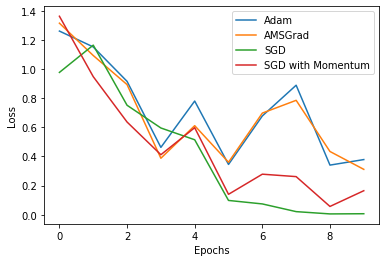

In [0]:
import matplotlib.pyplot as plt

# NOTE: In the plots below, because of 0-indexing, 0 on the x-axis corresponds to 1 epoch

# plot losses for each model 
for i, loss_history in enumerate(loss_histories):
  plt.plot(loss_history, label=labels[i])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

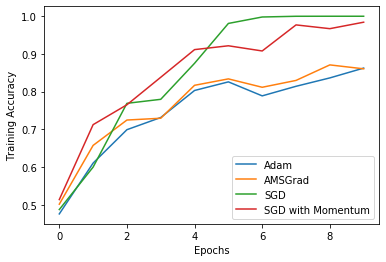

In [0]:
# plot accuracies on training set
for i, accuracy in enumerate(accuracies_train):
  plt.plot(accuracy, label=labels[i])
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.legend(loc='best')
plt.show()

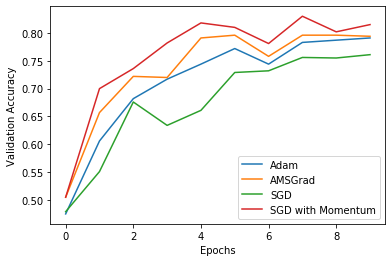

In [0]:
# plot accuracies on validation set
for i, accuracy in enumerate(accuracies_val):
  plt.plot(accuracy, label=labels[i])
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend(loc='best')
plt.show()

In [0]:
# evaluate accuracies on test set 
for model, optimizer in zip(models, labels):
  print('Optimizer: %s' % (optimizer))
  check_accuracy(loader_test, model, flag='test')

Optimizer: Adam
Checking accuracy on test set
Got 7939 / 10000 correct (79.39)
Optimizer: AMSGrad
Checking accuracy on test set
Got 7951 / 10000 correct (79.51)
Optimizer: SGD
Checking accuracy on test set
Got 7590 / 10000 correct (75.90)
Optimizer: SGD with Momentum
Checking accuracy on test set
Got 8139 / 10000 correct (81.39)


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
USE_GPU = True
dtype = torch.float32 

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print_every = 200

# function for test accuracy on validation and test set
def check_accuracy(loader, model, flag):
    if flag == 'training':
        print('Checking accuracy on training set')
    elif flag == 'validation':
      print('Checking accuracy on validation set')
    elif flag == 'test':
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))


def train_part(model, optimizer, epochs=1, scheduler=None):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Model accuracies during training.
    """

    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.to(device=device)
            model.train()  
            x = x.to(device=device, dtype=dtype)  # move data to device, e.g., GPU
            y = y.to(device=device, dtype=torch.long)
                       
            model.train() # put model to training mode
            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            loss.backward()

            # Update the parameters of the model using the gradients
            optimizer.step()

            if t == (len(loader_train)-1):
              if scheduler is not None:
                scheduler.step()
              
              check_accuracy(loader_train, model, flag='training')
              check_accuracy(loader_val, model, flag='validation')
              print()

            if t % print_every == 0:
              print('Epoch: %d, Iteration: %d, loss = %.4f' % (e, t, loss.item()))
              print()
            



In [0]:
# final model and optimizer to be trained  
learning_rate=0.00525
model_best_opt = ResNet18()
best_opt = optim.SGD(model_best_opt.parameters(), lr=learning_rate, momentum=0.875) #weight_decay=0.0001) 

In [0]:
# training 
train_part(model_best_opt, best_opt, epochs=10)

Epoch: 0, Iteration: 0, loss = 2.8536

Epoch: 0, Iteration: 200, loss = 2.0517

Epoch: 0, Iteration: 400, loss = 1.5514

Epoch: 0, Iteration: 600, loss = 1.5142

Checking accuracy on training set
Got 23914 / 49000 correct (48.80)
Checking accuracy on validation set
Got 491 / 1000 correct (49.10)

Epoch: 1, Iteration: 0, loss = 1.3755

Epoch: 1, Iteration: 200, loss = 1.1136

Epoch: 1, Iteration: 400, loss = 1.1802

Epoch: 1, Iteration: 600, loss = 1.0075

Checking accuracy on training set
Got 29907 / 49000 correct (61.03)
Checking accuracy on validation set
Got 591 / 1000 correct (59.10)

Epoch: 2, Iteration: 0, loss = 0.9318

Epoch: 2, Iteration: 200, loss = 1.0816

Epoch: 2, Iteration: 400, loss = 1.2678

Epoch: 2, Iteration: 600, loss = 1.2347

Checking accuracy on training set
Got 32573 / 49000 correct (66.48)
Checking accuracy on validation set
Got 661 / 1000 correct (66.10)

Epoch: 3, Iteration: 0, loss = 1.0903

Epoch: 3, Iteration: 200, loss = 0.9217

Epoch: 3, Iteration: 400, 

In [0]:
# evaluate accuracy on test set 
check_accuracy(loader_test, model_best_opt, flag='test')

Checking accuracy on test set
Got 8539 / 10000 correct (85.39)


0.8539

In [0]:
# save model
torch.save(model_best_opt.state_dict(), 'model_JD.pt')

The code provided below will allow you to visualise the feature maps computed by different layers of your network. Run the code (install matplotlib if necessary) and **answer the following questions**: 

1. Compare the feature maps from low-level layers to high-level layers, what do you observe? 

At layer one, we are able to observe result of the convolution function with respect to edges/curves (e.g., of a truck) in the input image, shown as bright green/yellow in the images below. We could call this local, or low-level learning. The output of the first layer (and its activation via a thresholding function) informs the features learnt by the next layer, and so on. In this way, convolutional networks are able to transform the volume of raw pixel values into class predictions at the output layer. In the images below we able to observe the effects of pooling/downsampling (smaller number pixels values) and the final, highly abstract representations learnt by the last layer of network. 

2. Use the training log, reported test set accuracy and the feature maps, analyse the performance of your network. If you think the performance is sufficiently good, explain why; if not, what might be the problem and how can you improve the performance?

I began by first experimenting with the effect of different optimisation algorithims by running backpropogation across four different optimisation objects simultaneously, using a constant learning rate of 0.005 and weight decay of 0.0001. I stored the loss, training accuracy and validation accuracy as a function of the number of epochs in arrays for visulisation purposes (see plots above). From this, I was able to deduce that SGD (with momentum) when compared with Adam (an adaptive algorithim) was able to make much greater peformance steps in early epochs and did not level off as quickly. Given this observation and the highest accuracy on the validation set (80%), I chose to use SGD. However, the plots also showed a near-100% accuracy on the training set. This was an indication of overfitting, so I augmented the data such that each image or its horizontal flip (p=0.5) was zero-padded and randomly cropped. Re-running the training with carefully tuned hyperparamters (lr=0.00525 with no decay, momentum=0.825, no weight decay, as it was reducing capacity), I was able to achieve an accuracy of 86% on the validation set and 85% on the hold-out set. I believe this accuracy can be improved upon with more epochs (at epoch 10 the validation accuracy does not appear to have fully saturated) and a more optimal set of hyperparmater values found through a grid search or random search (as described above), as they are difficult to find by trial and error. With that said, there is research that shows that for deep networks, most local minima are equivalent and lead to a similar peformance on a test set (Choromanska et al., 2015). Interestingly, in the feature maps of the last layer below, it is possible to pick out repeated representations (i.e., different images belonging to the same class), which visually demonstrates the network has been trained successfully to a relatively high accuracy. 

3. What are the other possible ways to analyse the performance of your network?

In addition to the above, we could better monitor the loss and the training/validation accuracy by peforming *k* rounds of learning, leaving *1/k* of the dataset out as a test set in each cycle (cross validation). The average test accuracy would then provide a better estimate than a single score. Because this is a clasification task, we could also produce a confusion matrix, compute the F1 statistic (weighted mean of precision and recall) for each class in a one-versus-all fashion and report the average F1 score (1 representing perfect precision and recall, 0 representing the worst performance). This would be a better way to measure the predictive power of the network as accuracy is prone to class imbalance. Lastly, as further way to test the generalisation properties of the network, one could perform experiments with adversarial examples to test the robustness of the learned features (Jo & Bengio, 2017), for example by pertubing the input and seeing whether the abstractions are preserved.  



**YOUR ANSWER FOR PART 3 HERE**

All questions answered above.

<Figure size 432x288 with 0 Axes>

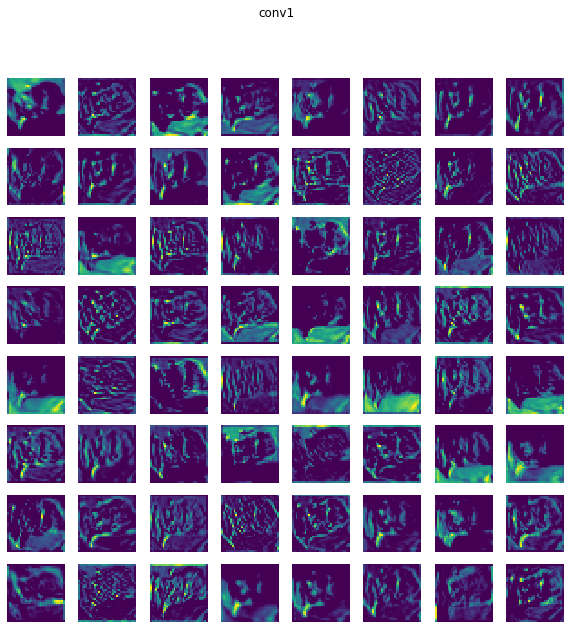

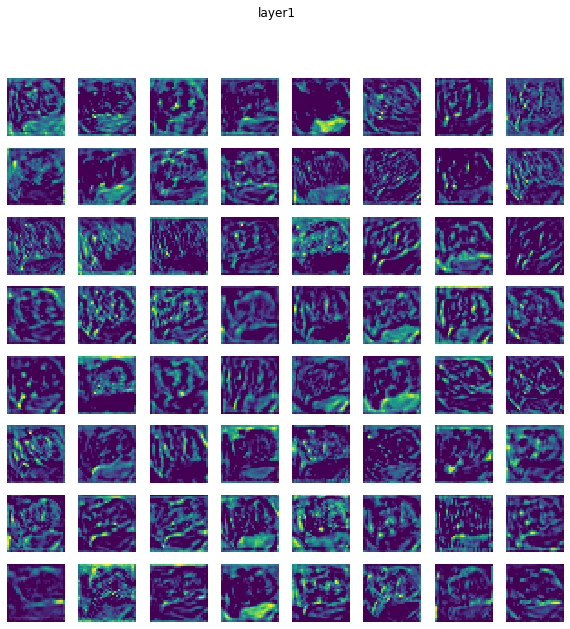

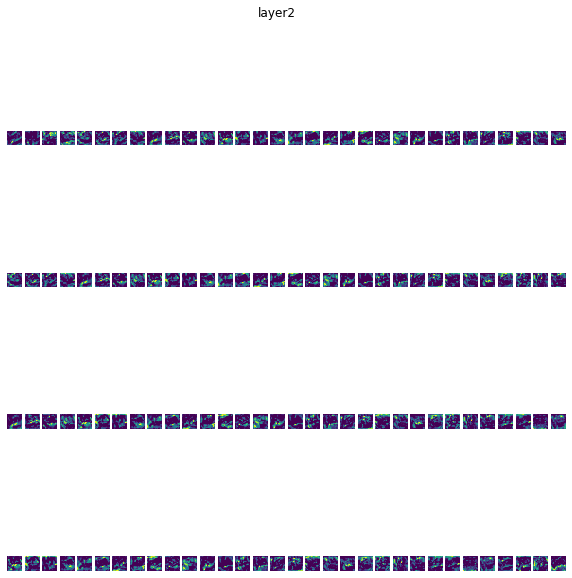

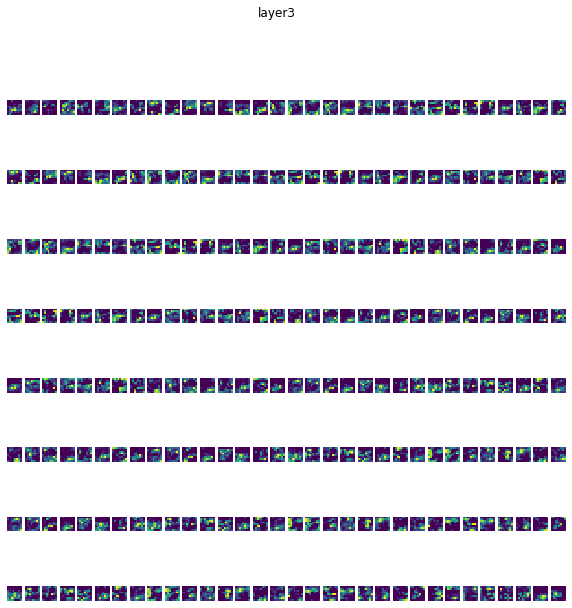

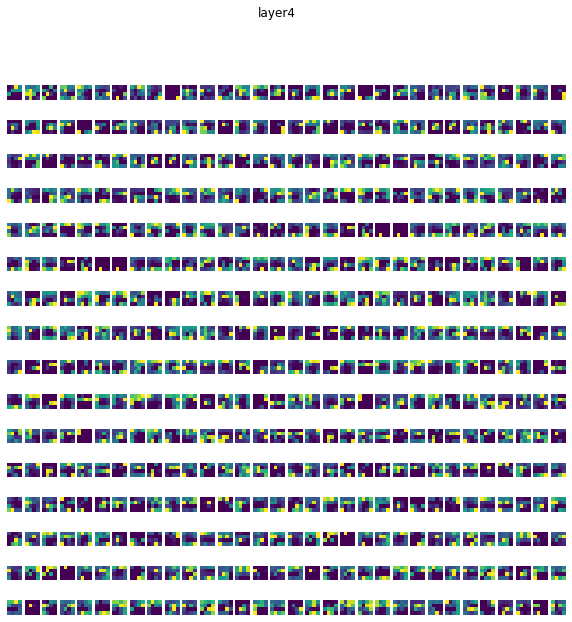

In [0]:
#!pip install matplotlib
import matplotlib.pyplot as plt

plt.tight_layout()



activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

vis_labels = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4']

for l in vis_labels:

    getattr(model_best_opt, l).register_forward_hook(get_activation(l))
    
    
data, _ = cifar10_test[0]
data = data.unsqueeze_(0).to(device = device, dtype = dtype)

output = model_best_opt(data)



for idx, l in enumerate(vis_labels):

    act = activation[l].squeeze()

    if idx < 2:
        ncols = 8
    else:
        ncols = 32
        
    nrows = act.size(0) // ncols
    
    fig, axarr = plt.subplots(nrows, ncols, figsize=(10,10))
    fig.suptitle(l)


    for i in range(nrows):
        for j in range(ncols):
            axarr[i, j].imshow(act[i * nrows + j].cpu())
            axarr[i, j].axis('off')